In [1]:
import networkx as nx
import matplotlib
from sklearn import datasets
from sklearn.neighbors import KDTree
import time
from torch_geometric.nn import aggr
import matplotlib.pyplot as plt
from torchvision.ops import MLP
from torch_geometric.nn.conv import PointNetConv
import numpy as np
from torch import Tensor
from torch.nn import Dropout
import torch, torch_geometric
import torch_optimizer as optim
from sklearn.model_selection import train_test_split
from copy import deepcopy
from itertools import combinations
import idx2numpy
import random
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Function transforming images into graphs

def image2graph(image, target, r=4):

    # Graph node properties
    x = torch.tensor(image[image > 0].reshape(-1, 1), dtype=torch.float)
    
    # Graph global property
    y = torch.tensor(target, dtype=torch.long) 

    # Building Adjacency List and saving the position of the nodes
    adj_list = []
    edge_attrs = []
    pos = np.array(np.nonzero(image)).T.reshape(-1, 2)
    tree = KDTree(pos, leaf_size=10)  
    ind, dist = tree.query_radius(pos, r=r, return_distance=True)
    for i, d in zip(ind, dist):
        source = i[d==0][0]
        neighbors = i[d>0]
        edge_attr = d[d>0]
        for neighbor, edge_len in zip(neighbors, edge_attr):
            adj_list.append([source, neighbor])
            edge_attrs.append([1./edge_len])
        
    edge_index = torch.tensor(adj_list, dtype=torch.long)
    edge_attrs = torch.tensor(edge_attrs, dtype=torch.float)
    pos = torch.tensor(pos, dtype=torch.float)
    
    data = torch_geometric.data.Data(x=x, edge_index=edge_index.t().contiguous(), y=y, edge_attr=edge_attrs, pos=pos)

    return data

Load MNIST 8x8 dataset

In [3]:
# loading the dataset
digits = datasets.load_digits()

# Information about the dataset
npoints, xres, yres = digits.images.shape
print('The number of data points in the dataset is {:d}'.format(npoints))
print('The image resolution is {:d}x{:d}'.format(xres, yres))

# Splitting into train and test and normalize inputs from 0-16 to 0-1
data_train_n, data_test_n, labels_train_n, labels_test_n = train_test_split(digits.images/16, digits.target, test_size=0.5)

The number of data points in the dataset is 1797
The image resolution is 8x8


In [4]:
%%time
# Building the graphs for the MNIST with the radius (r) of connected pixels equal to 4

dataset_train_n = []
for image, target in zip (data_train_n, labels_train_n):
    dataset_train_n.append(image2graph(image,target,r=4))

dataset_test_n = []
for image, target in zip (data_test_n, labels_test_n):
     dataset_test_n.append(image2graph(image,target,r=4))

CPU times: user 2 s, sys: 16 ms, total: 2.02 s
Wall time: 2.02 s


 Graph corresponds to the number:  5
 Number of nodes: 30
 Number of edges: 538
 Number of node features: 1



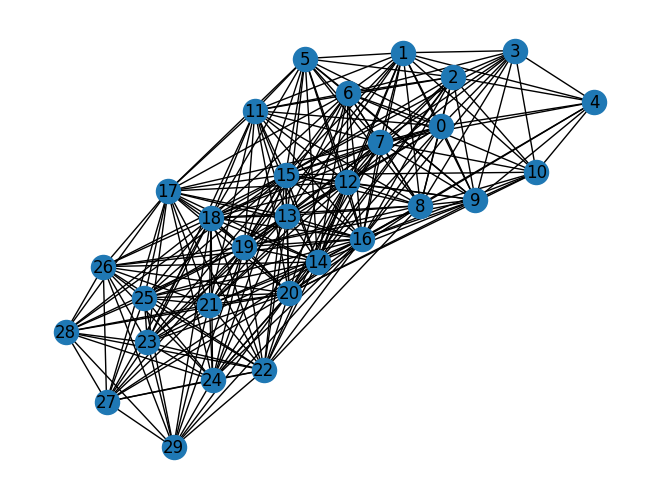

In [5]:
# Visualizing a graph from the MNIST train dataset

data = list(dataset_train_n)[0]
print(' Graph corresponds to the number: ', data.y.item())
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, with_labels=True)
print(' Number of nodes: {:d}\n Number of edges: {:d}\n Number of node features: {:d}\n'.
      format(data.num_nodes, data.num_edges, data.num_node_features))

Load Fashion MNIST 28x28 dataset

In [6]:
# Read data
X_train = idx2numpy.convert_from_file('fashion MNIST/train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file('fashion MNIST/train-labels-idx1-ubyte')
X_test = idx2numpy.convert_from_file('fashion MNIST/t10k-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file('fashion MNIST/t10k-labels-idx1-ubyte')

# Reshape to be [samples][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28).astype('float32')

# Normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [7]:
# Information about the dataset

npoints, xres, yres = X_train.shape
print('The number of data points in the dataset is {:d}'.format(npoints))
print('The image resolution is {:d}x{:d}'.format(xres, yres))

The number of data points in the dataset is 60000
The image resolution is 28x28


In [8]:
# Splitting into test and train datasets of smaller sizes. 
# y_train+10 and y_test+10 to shift the labels wrt the first MNIST dataset.

data_train_f, _, labels_train_f, _ = train_test_split(X_train, y_train+10, train_size=2000)
data_test_f, _, labels_test_f, _ = train_test_split(X_test, y_test+10, train_size=1000)

In [9]:
%%time
# Building the graphs for the MNIST with the radius (r) of connected pixels equal to 4

dataset_train_f = []
for image, target in zip (data_train_f, labels_train_f):
    dataset_train_f.append(image2graph(image,target,r=4))

dataset_test_f = []
for image, target in zip (data_test_f, labels_test_f):
     dataset_test_f.append(image2graph(image,target,r=4))

CPU times: user 2min 20s, sys: 581 ms, total: 2min 21s
Wall time: 2min 21s


In [10]:
# Merging two datasets into one

dataset_train = dataset_train_n + dataset_train_f
dataset_test = dataset_test_n + dataset_test_f

# Random shuffling of the train dataset
random.shuffle(dataset_train)

# Labels names in the final dataset
labels_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Building the GCNN

In [11]:
# Some global properties needed

num_node_features = data.num_node_features
num_classes = len(labels_names)

In [12]:
class PointNet(torch.nn.Module):
    '''
    A simple PointNet-inspired network with three PointNetConv layers followed by a global Max aggregation,
    Dropout and MLP classification layers
    '''
    
    def __init__(self):
        super().__init__()

        self.conv1 = PointNetConv(MLP(in_channels=3, hidden_channels=(24, 24), activation_layer=torch.nn.ReLU), 
                                  MLP(in_channels=24, hidden_channels=(24, 24), activation_layer=torch.nn.ReLU))
        self.conv2 = PointNetConv(MLP(in_channels=26, hidden_channels=(24, 24), activation_layer=torch.nn.ReLU), 
                                  MLP(in_channels=24, hidden_channels=(24, 24), activation_layer=torch.nn.ReLU))
        self.conv3 = PointNetConv(MLP(in_channels=26, hidden_channels=(48, 48), activation_layer=torch.nn.ReLU), 
                                  MLP(in_channels=48, hidden_channels=(48, 48), activation_layer=torch.nn.ReLU))
        self.classifier = MLP(in_channels=48, hidden_channels=(128, num_classes), activation_layer=torch.nn.ReLU)
        self.dropout = Dropout(p=0.2)
        self.pool = aggr.MaxAggregation()

    def forward(self, data):

        x, pos, edge_index = data.x, data.pos, data.edge_index

        # Convolution
        h = self.conv1(x, pos, edge_index)
        h = self.conv2(h, pos, edge_index)
        h = self.conv3(h, pos, edge_index)

        # Global Pooling:
        h = self.pool(h)

        # Dropout
        h = self.dropout(h)

        # Classifier:        
        return self.classifier(h)

In [13]:
# Training the network

model = PointNet()
optimizer = optim.AdaBelief(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
best_test_acc = torch.zeros(1)
best_state_dict = dict()
n_epoch = 200

# Train step
def train():
    model.train()

    total_loss = 0
    for data in dataset_train:
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(torch.flatten(logits), data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)

    return total_loss / len(dataset_train)

# Evaluation on the test set
@torch.no_grad()
def test():
    model.eval()

    total_correct = 0
    for data in dataset_test:
        logits = model(data)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(dataset_test)

# Training
early_stop = 0
for epoch in range(1, n_epoch+1):
    loss = train()
    test_acc = test()
    best_epoch = False
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_state_dict = deepcopy(model.state_dict())
        best_epoch = True
        torch.save(best_state_dict, 'best_model.pt')
        early_stop = 0
    if best_epoch:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f} - best epoch')
    else:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')
        early_stop += 1
    if early_stop == 20:
        break

# Loading the best model
model.load_state_dict(best_state_dict)

test_acc = test()
print(f'Final Test Acc: {test_acc:.4f}')

Epoch: 01, Loss: 2.4043, Test Acc: 0.2180 - best epoch
Epoch: 02, Loss: 1.8189, Test Acc: 0.3728 - best epoch
Epoch: 03, Loss: 1.4451, Test Acc: 0.4408 - best epoch
Epoch: 04, Loss: 1.2215, Test Acc: 0.5429 - best epoch
Epoch: 05, Loss: 1.0685, Test Acc: 0.6251 - best epoch
Epoch: 06, Loss: 0.9486, Test Acc: 0.7014 - best epoch
Epoch: 07, Loss: 0.8642, Test Acc: 0.7251 - best epoch
Epoch: 08, Loss: 0.8010, Test Acc: 0.7578 - best epoch
Epoch: 09, Loss: 0.7490, Test Acc: 0.7578
Epoch: 10, Loss: 0.7294, Test Acc: 0.7994 - best epoch
Epoch: 11, Loss: 0.7116, Test Acc: 0.8052 - best epoch
Epoch: 12, Loss: 0.6858, Test Acc: 0.7988
Epoch: 13, Loss: 0.6854, Test Acc: 0.8289 - best epoch
Epoch: 14, Loss: 0.6415, Test Acc: 0.8057
Epoch: 15, Loss: 0.6184, Test Acc: 0.8273
Epoch: 16, Loss: 0.6273, Test Acc: 0.8046
Epoch: 17, Loss: 0.6253, Test Acc: 0.8141
Epoch: 18, Loss: 0.6083, Test Acc: 0.8041
Epoch: 19, Loss: 0.5962, Test Acc: 0.7873
Epoch: 20, Loss: 0.6034, Test Acc: 0.8289
Epoch: 21, Loss: 

In [14]:
# Improving the model with smaller optimizer steps

optimizer = optim.AdaBelief(model.parameters(), lr=0.0001)
n_epoch = 50

early_stop = 0
for epoch in range(1, n_epoch+1):
    loss = train()
    test_acc = test()
    best_epoch = False
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_state_dict = deepcopy(model.state_dict())
        best_epoch = True
        torch.save(best_state_dict, 'best_model.pt')
        early_stop = 0
    if best_epoch:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f} - best epoch')
    else:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')
        early_stop += 1
    if early_stop == 20:
        break

model.load_state_dict(best_state_dict)

test_acc = test()
print(f'Final Test Acc: {test_acc:.4f}')

Epoch: 01, Loss: 0.3134, Test Acc: 0.8763 - best epoch
Epoch: 02, Loss: 0.2802, Test Acc: 0.8826 - best epoch
Epoch: 03, Loss: 0.2660, Test Acc: 0.8773
Epoch: 04, Loss: 0.2548, Test Acc: 0.8773
Epoch: 05, Loss: 0.2424, Test Acc: 0.8768
Epoch: 06, Loss: 0.2294, Test Acc: 0.8799
Epoch: 07, Loss: 0.2225, Test Acc: 0.8778
Epoch: 08, Loss: 0.2248, Test Acc: 0.8868 - best epoch
Epoch: 09, Loss: 0.2095, Test Acc: 0.8799
Epoch: 10, Loss: 0.1982, Test Acc: 0.8831
Epoch: 11, Loss: 0.2037, Test Acc: 0.8852
Epoch: 12, Loss: 0.1953, Test Acc: 0.8863
Epoch: 13, Loss: 0.1911, Test Acc: 0.8841
Epoch: 14, Loss: 0.1834, Test Acc: 0.8789
Epoch: 15, Loss: 0.1816, Test Acc: 0.8836
Epoch: 16, Loss: 0.1697, Test Acc: 0.8752
Epoch: 17, Loss: 0.1737, Test Acc: 0.8852
Epoch: 18, Loss: 0.1693, Test Acc: 0.8847
Epoch: 19, Loss: 0.1724, Test Acc: 0.8778
Epoch: 20, Loss: 0.1707, Test Acc: 0.8789
Epoch: 21, Loss: 0.1520, Test Acc: 0.8773
Epoch: 22, Loss: 0.1561, Test Acc: 0.8784
Epoch: 23, Loss: 0.1568, Test Acc: 0.

(1899,) (1899,)
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        91
           1       0.92      0.98      0.95        90
           2       0.99      0.97      0.98        87
           3       0.94      0.96      0.95        94
           4       0.93      0.96      0.95        84
           5       0.97      0.96      0.96        90
           6       0.94      1.00      0.97        95
           7       0.98      0.96      0.97        96
           8       0.93      0.87      0.90        92
           9       0.94      0.90      0.92        80
 T-shirt/top       0.74      0.74      0.74        96
     Trouser       0.97      0.97      0.97        91
    Pullover       0.72      0.76      0.74       115
       Dress       0.81      0.84      0.83       108
        Coat       0.67      0.67      0.67        95
      Sandal       0.97      0.94      0.95       112
       Shirt       0.60      0.54      0.5

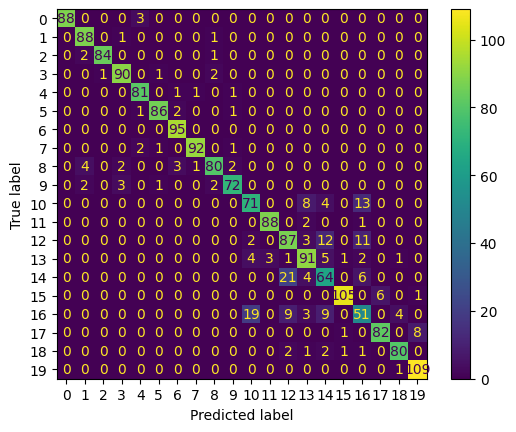

In [15]:
# Analyze the results for the test set
class_names = list(range(20))

# Predicting
predicted = []
for data in dataset_test:
    predicted.append(torch.argmax(model.forward(data), dim=1).numpy())

predicted = np.array(predicted).flatten()

labels_test = np.array([_.y.numpy() for _ in dataset_test])

print(labels_test.shape, predicted.shape)

print(
    f"Classification report:\n"
    f"{metrics.classification_report(labels_test, predicted, labels=class_names, target_names=labels_names)}\n"
)

# Confusion matrix
cm = confusion_matrix(labels_test, predicted, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()
plt.show()

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       0.97      1.00      0.98        92
           2       1.00      1.00      1.00        90
           3       1.00      1.00      1.00        89
           4       1.00      1.00      1.00        97
           5       1.00      1.00      1.00        92
           6       1.00      1.00      1.00        86
           7       1.00      1.00      1.00        83
           8       1.00      0.96      0.98        82
           9       1.00      1.00      1.00       100
 T-shirt/top       0.84      0.87      0.86       188
     Trouser       1.00      0.99      0.99       214
    Pullover       0.78      0.84      0.81       204
       Dress       0.89      0.95      0.92       189
        Coat       0.86      0.85      0.85       237
      Sandal       0.99      0.99      0.99       177
       Shirt       0.83      0.70      0.76       220
    

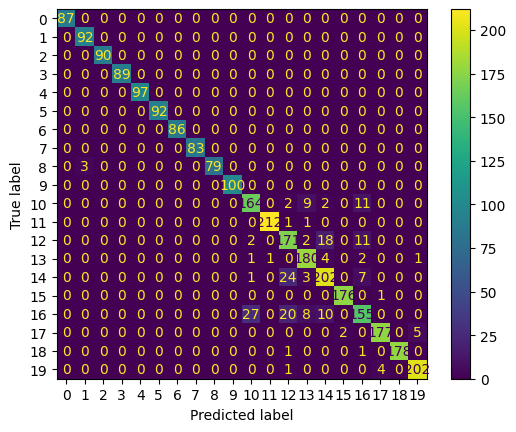

In [16]:
# Analyze the results for the train set

predicted = []
for data in dataset_train:
    predicted.append(torch.argmax(model.forward(data), dim=1).numpy())

predicted = np.array(predicted).flatten()
labels_train = np.array([_.y.numpy() for _ in dataset_train])

print(
    f"Classification report:\n"
    f"{metrics.classification_report(labels_train, predicted, labels=class_names, target_names=labels_names)}\n"
)

# Confusion matrix
cm = confusion_matrix(labels_train, predicted, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot()
plt.show()